# Project Goals

- examine various recomendation systems with and without user ratings. 



# Imports & Getting the data

In [520]:
from random import gauss as gs, uniform as uni, seed
import numpy as np
import pandas as pd
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
    
import matplotlib.pyplot as plt

In [476]:
movies = pd.read_csv('Data/movies.csv')
ratings = pd.read_csv('Data/ratings.csv')
tags = pd.read_csv('Data/tags.csv')

## Examining & Cleaning the Data!

The movie and rating CSVs are fairly self-explainatory (providing movies, reviews, and users), so we'll start there.

In [456]:
def get_movie_name(movie_id):
    try:
        return movies.loc[movie_id, 'title']
    except KeyError:
        return "Movie not found"
    
def get_movie_genres(movie_id):
    try:
        return movies.loc[movie_id, 'genres']
    except KeyError:
        return "Movie not found"
    
def get_movie_year(movie_id):
    try:
        return movies.loc[movie_id, 'year']
    except KeyError:
        return "Movie not found"
    
def get_movie_rating(movie_id):
    try:
        rating = movies.loc[movie_id, 'avg_rating']
        return f'{round(rating,2)}'
    except KeyError:
        return "Movie rating not found"
    
def get_movie_num_reviews(movie_id):
    try:
        num = movies.loc[movie_id, 'num_reviews']
        return f'{int(num)} users'
    except KeyError:
        return " "    

def movie_pretty_string(movie_id):
    try:
        string = f'{get_movie_name(movie_id)}, {get_movie_year(movie_id)}   | {get_movie_rating(movie_id)} by {get_movie_num_reviews(movie_id)} users |  {get_movie_genres(movie_id)}'
        return string
    except KeyError:
        return "Movie not found"

### Movies

In [457]:
#Problems: Year is tied into the title, no reviews, genres are a pipe separated list, ids are present, but not the indexes 
movies.set_index('movieId', inplace=True)
movies.sample(5)

,title,genres
movieId,,
917,"Little Princess, The (1939)",Children|Drama
5591,Monkey Trouble (1994),Children|Comedy
26413,Snake in the Eagle's Shadow (Se ying diu sau) ...,Action|Comedy
5248,Smokey and the Bandit III (1983),Action|Comedy
3535,American Psycho (2000),Crime|Horror|Mystery|Thriller


In [458]:
#Get the year from title
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True).astype(str)
movies['title'] = movies.title.str[:-7]

In [459]:
#Add the mean rating for each movie 
ratings_movie_mean = ratings.groupby('movieId').mean()
mean_rating = ratings.groupby('movieId').mean()['rating']
movies['avg_rating'] = mean_rating
movies['num_reviews'] = ratings.groupby('movieId').count()['rating']

In [460]:
fig = px.bar(temp_year, x='year', y='avg_rating', hover_data=['title', 'num_reviews'])

fig.update_layout(
    title_text='Movies', # title of plot
    xaxis_title_text='Year', # xaxis label
    yaxis_title_text='Number of Movies Released', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()


In [461]:
df_temp = movies
df_temp['decade'] = df_temp['year'].str[:3]+'0s'
movies['decade'] = df_temp['year'].str[:3]+'0s'
df_temp = df_temp.groupby(['decade'])['title'].count()
df_temp

fig = px.bar(df_temp, text_auto=True)

fig.update_layout(
    title_text='Movies released per decade', # title of plot
    xaxis_title_text='Decade', # xaxis label
    yaxis_title_text='Number of Movies Released', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()

In [462]:
#make the genres a csv
def unpack_genres(string):
    s = string.split('|')
    return s

movies['genres'] = movies['genres'].map(unpack_genres)

In [463]:
unique_genres = [ ]
for row in movies['genres']:
    for genre in row:
        if genre not in unique_genres:
            unique_genres.append(genre)

unique_genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']

### Creating a sparse matrix of Genres

In [485]:
movie_genre_matrix = pd.DataFrame()
movie_genre_matrix['movieId'] = movies.index

for genre in unique_genres:
    movie_genre_matrix[genre] = movies['genres'].apply(lambda x: 1 if genre in x else 0)

for col in movie_genre_matrix.columns:
    summ = movie_genre_matrix[col].sum()
    print(f'{col} has {summ} movies')


movieId has 47448411 movies
Adventure has 1263 movies
Animation has 611 movies
Children has 664 movies
Comedy has 3756 movies
Fantasy has 779 movies
Romance has 1596 movies
Drama has 4361 movies
Action has 1828 movies
Crime has 1199 movies
Thriller has 1894 movies
Horror has 978 movies
Mystery has 573 movies
Sci-Fi has 980 movies
War has 382 movies
Musical has 334 movies
Documentary has 440 movies
IMAX has 158 movies
Western has 167 movies
Film-Noir has 87 movies
(no genres listed) has 34 movies


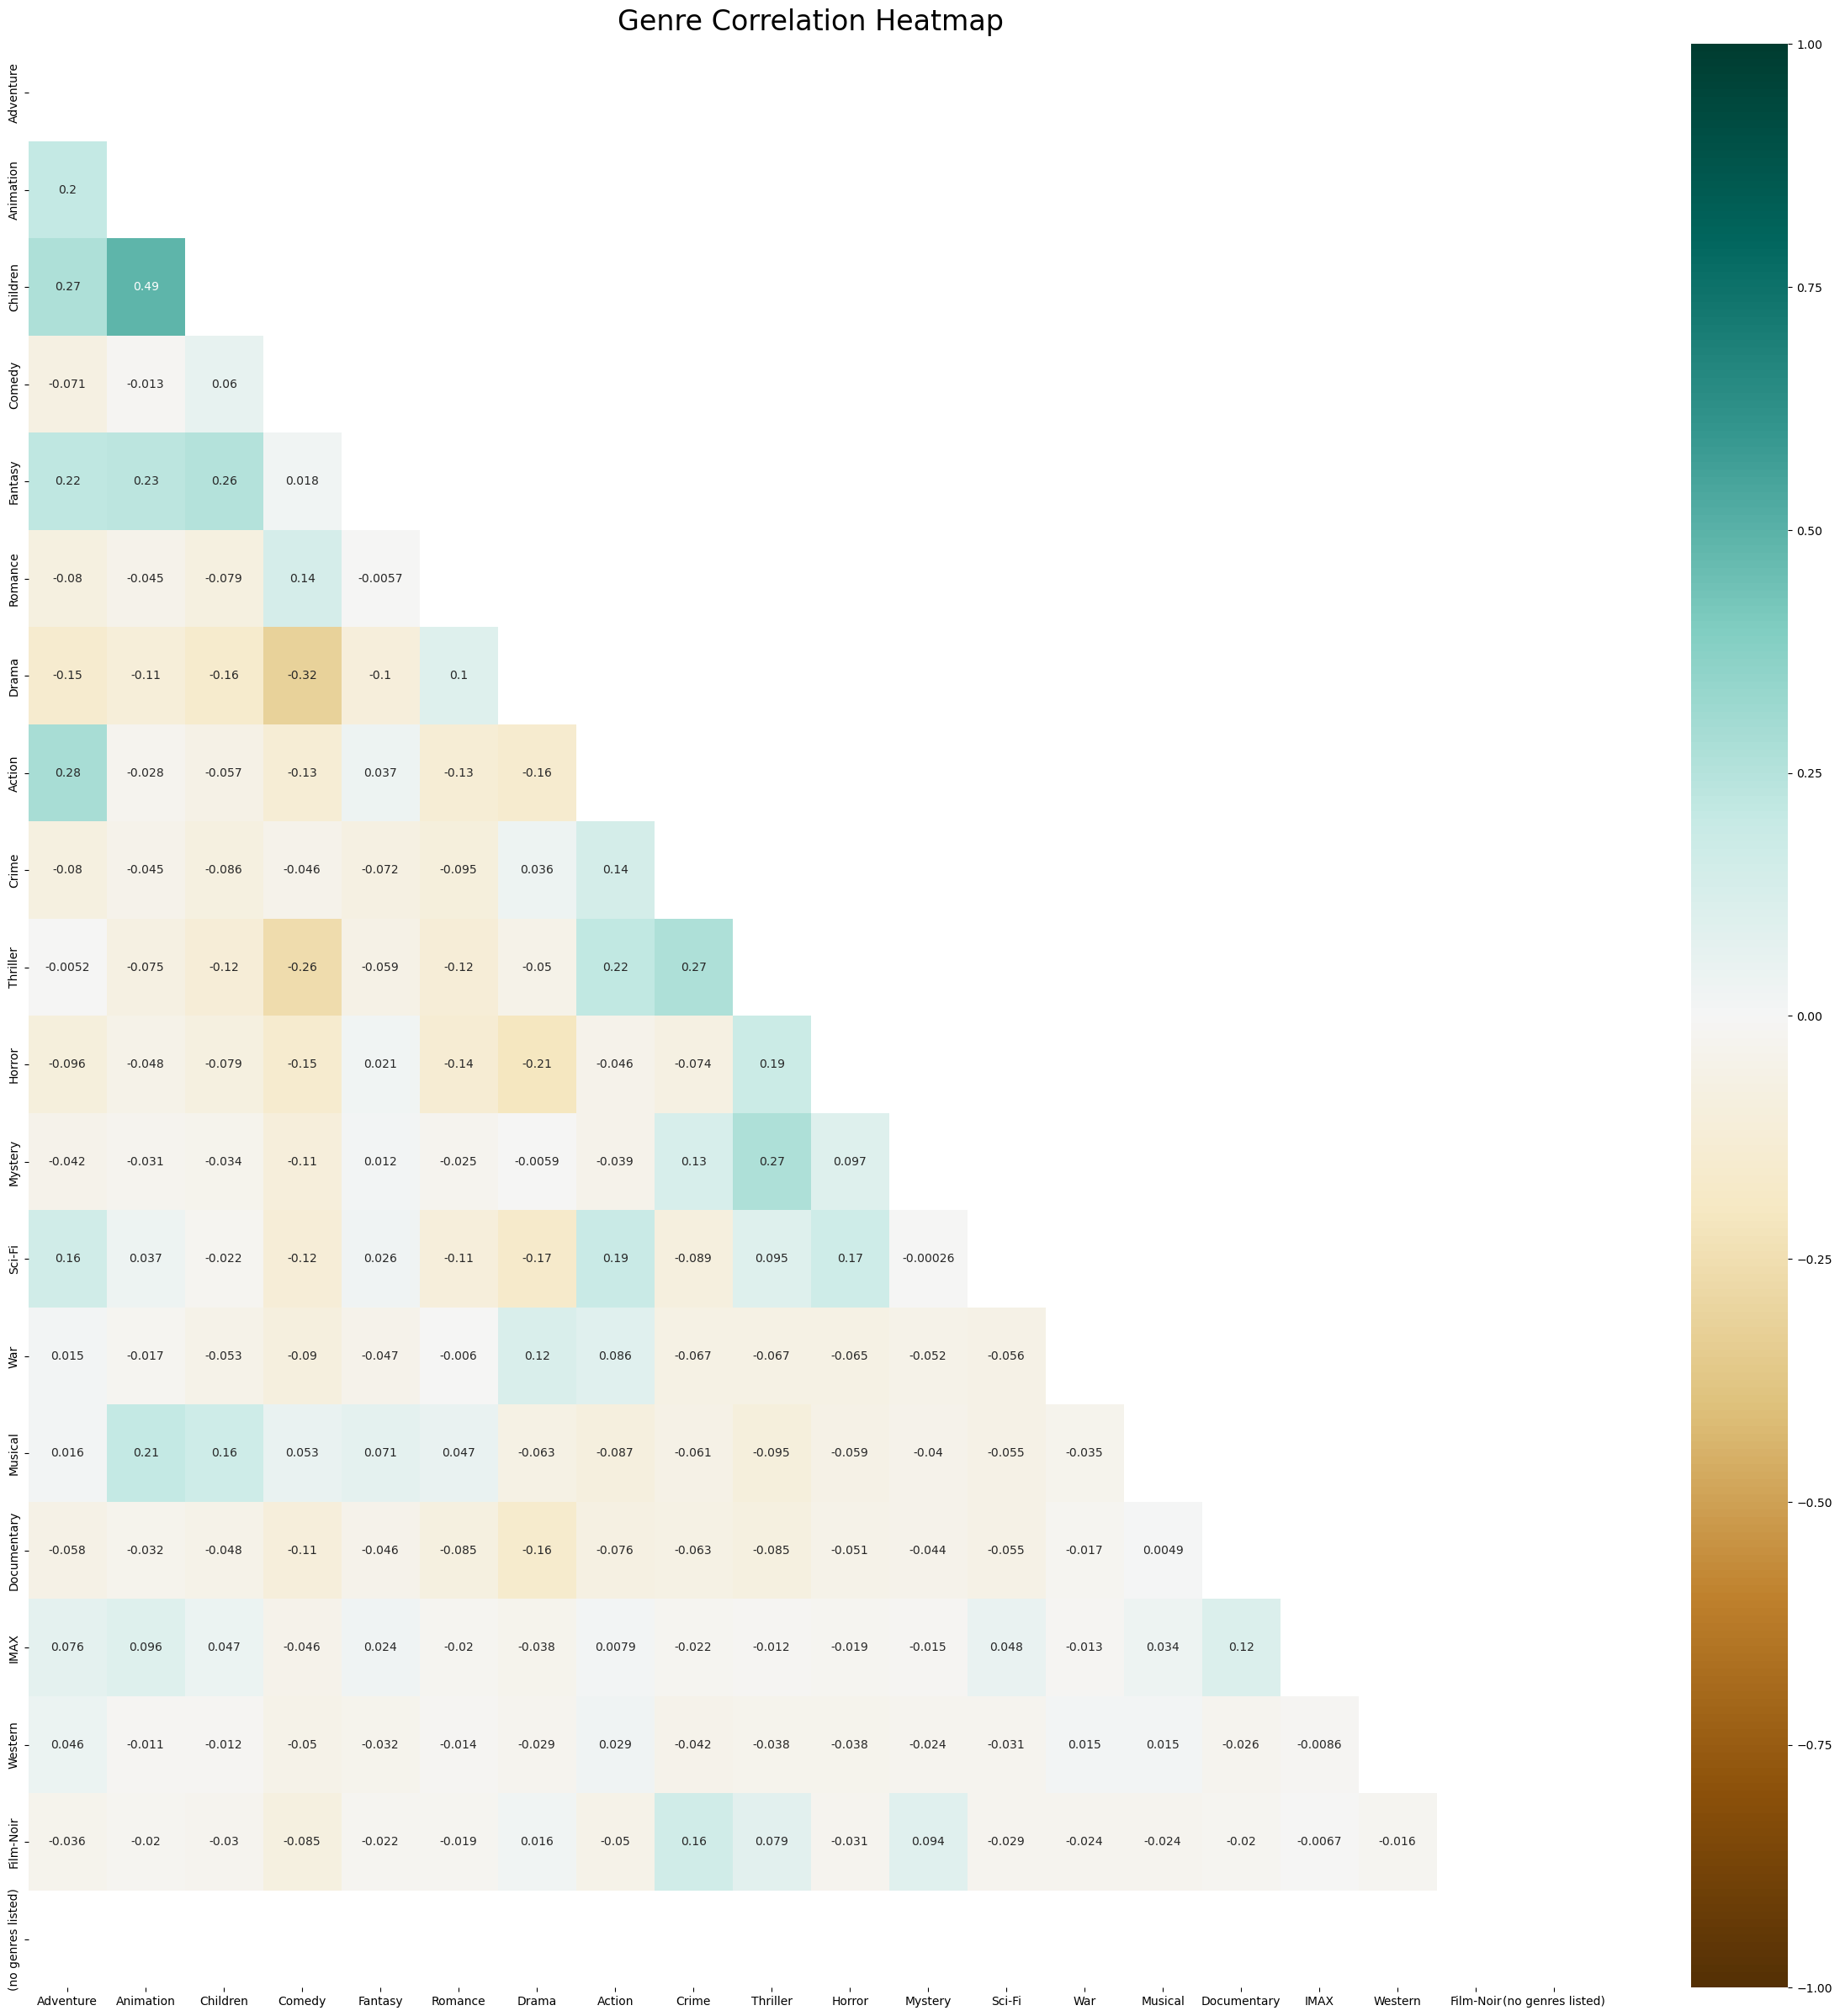

In [465]:
df_matrix = movie_genre_matrix.drop(columns='movieId')

corr_matrix = df_matrix.corr()

plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

heatmap = sns.heatmap(corr_matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Genre Correlation Heatmap', fontdict={'fontsize':24}, pad=12);

In [466]:
#looks good! 
movies

,title,genres,year,avg_rating,num_reviews,decade
movieId,,,,,,
1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,3.920930,215.0,1990s
2,Jumanji,"[Adventure, Children, Fantasy]",1995,3.431818,110.0,1990s
3,Grumpier Old Men,"[Comedy, Romance]",1995,3.259615,52.0,1990s
4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,2.357143,7.0,1990s
5,Father of the Bride Part II,[Comedy],1995,3.071429,49.0,1990s
...,...,...,...,...,...,...
193581,Black Butler: Book of the Atlantic,"[Action, Animation, Comedy, Fantasy]",2017,4.000000,1.0,2010s
193583,No Game No Life: Zero,"[Animation, Comedy, Fantasy]",2017,3.500000,1.0,2010s
193585,Flint,[Drama],2017,3.500000,1.0,2010s


### Ratings 

In [467]:
#problem: timestamp not human readable, nice to have real names as well
ratings.sample(5)

,userId,movieId,rating,timestamp
92289,597,1193,5.0,941640888
26111,182,69,3.0,1054784267
22586,153,138396,3.5,1525551207
2773,19,2617,3.0,965705018
48506,313,3535,4.0,1030475654


In [468]:
#times now datetime 
ratings['timestamp'] = ratings['timestamp'].map(datetime.fromtimestamp)

In [469]:
ratings['title'] = ratings['movieId'].map(get_movie_name)

In [470]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,100836
mean,326.127564,19435.295718,3.501557,2008-03-19 12:38:29.931839488
min,1.000000,1.000000,0.500000,1996-03-29 13:36:55
25%,177.000000,1199.000000,3.000000,2002-04-18 05:57:46
50%,325.000000,2991.000000,3.500000,2007-08-02 16:31:02
75%,477.000000,8122.000000,4.000000,2015-07-04 03:15:44.500000
max,610.000000,193609.000000,5.000000,2018-09-24 10:27:30
std,182.618491,35530.987199,1.042529,NaN


## Visualizing the Data

In [401]:
temp_year = movies.sort_values(by=['year'])
fig = px.scatter(temp_year, x='year', y='avg_rating', hover_data=['title', 'num_reviews'])

fig.update_layout(
    title_text='Movies ratings by Year', # title of plot
    xaxis_title_text='Year', # xaxis label
    yaxis_title_text='Rating', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()

In [402]:
df_temp = movies.groupby('decade').mean(numeric_only=True)

fig = px.bar(df_temp, y='avg_rating', text_auto=True)

fig.update_layout(
    title_text='Average Reviews of movies per decade', # title of plot
    xaxis_title_text='Decade', # xaxis label
    yaxis_title_text='Average Rating', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()

In [403]:

fig = px.histogram(ratings, x='rating', 
                            text_auto=True,
                            labels={'x':'rating', 'y':'count'},
                            color='rating',
                            color_discrete_sequence=["SandyBrown", "Gold", 'Coral', 'Salmon', "OrangeRed", 'SandyBrown', "Coral", 'Salmon', "red", 'OrangeRed'],
                            )

fig.update_layout(
    title_text='Number of Ratings', # title of plot
    xaxis_title_text='Rating', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()

In [404]:
temp_df = ratings.groupby(['title', 'movieId']).count().sort_values(by='rating',ascending=False).reset_index().iloc[0:10,:]

temp_df['average rating'] = temp_df['movieId'].map(get_movie_rating)

fig = px.bar(temp_df, x = 'title', y = 'userId',text_auto=True, hover_data='average rating')

fig.update_layout(
    title_text='Most frequently rated movies', # title of plot
    xaxis_title_text='Movie', # xaxis label
    yaxis_title_text='Number of Ratings', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()

In [420]:
#The average movie has 14 reviews
rated_movies = movies.loc[movies['num_reviews'] >= 14]

# Find Highest rated movies:
top_10 = rated_movies.sort_values(by=['avg_rating','num_reviews'],ascending=False)[:10]


fig = px.bar(top_10, x = 'title', y = 'avg_rating',text_auto=True)
fig.update_layout(
    title_text='Higest rated movies with more than 14 reviews', # title of plot
    xaxis_title_text='Movie', # xaxis label
    yaxis_title_text='Number of Ratings', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)
fig.update_yaxes(range=[0, 5])  
fig.show()

# Lowest rated movies
lowest_10 = rated_movies.sort_values(by=['avg_rating','num_reviews'],ascending=True)[:10]

fig = px.bar(lowest_10, x = 'title', y = 'avg_rating',text_auto=True)
fig.update_layout(
    title_text='Lowest rated movies with more than 14 reviews', # title of plot
    xaxis_title_text='Movie', # xaxis label
    yaxis_title_text='Number of Ratings', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)
fig.update_yaxes(range=[0, 5])  

fig.show()

# Cosine Similarity for Movie Genres (Item Based Recomendation, No Users)

The cosine similarity is a metric to determine how similar different things are. 

In [489]:
from sklearn.metrics.pairwise import cosine_similarity

In [503]:
#get a random movie
test_movie = np.random.choice(movies.shape[0])
get_movie_name(test_movie)

'Titus (1999)'

In [506]:
def top_k_items(item_id, top_k, corr_mat, map_name):

    # sort correlation value ascendingly and select top_k item_id
    top_items = corr_mat[item_id,:].argsort()[-top_k:]
    top_items = [map_name[e] for e in top_items]

    return top_items


# compute similarity matix
corr_mat = cosine_similarity(movie_genre_matrix)

# get top-k similar items
ind2name = {ind:name for ind,name in enumerate(movie_genre_matrix.index)}
name2ind = {v:k for k,v in ind2name.items()}
similar_items = top_k_items(name2ind[test_movie],
                            top_k = 3,
                            corr_mat = corr_mat,
                            map_name = ind2name)

# display result
print(f'The top-3 similar movie to: {get_movie_name(test_movie)}')
for movie in similar_items:
    print(f'Movie: {get_movie_name(movie)}')
    print(f'        Correlation: {corr_mat[movie]}')
    print(f'        Genres: {get_movie_genres(movie)}')

The top-3 similar movie to: Titus (1999)
Movie: Third Miracle, The (1999)
        Correlation: [0.         0.49999996 0.81649651 ... 0.99999995 0.9999999  0.99999991]
        Genres: Drama
Movie: Angela's Ashes (1999)
        Correlation: [0.         0.49999996 0.81649651 ... 0.99999995 0.9999999  0.99999991]
        Genres: Drama
Movie: Titus (1999)
        Correlation: [0.         0.49999996 0.81649651 ... 0.99999995 0.9999999  0.99999991]
        Genres: Drama


This provides us a general reccomendation for movies based on shared genres. 

# K-Nearest Neighbors (Item Based Reccomendation, Collaborative)

Note: This is not a classifier or regression, so there is no train test split or validation. It is another distance comparison

In [522]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

In [523]:
#make a pivot table containing movies, ratings, and user Ids
data = pd.merge(movies,ratings)
#fill unrated movies with 0s because KNN does not like nas
user_movie_table = data.pivot_table(index = ["title"],columns = ["userId"],values = "rating").fillna(0)
user_movie_table.sample(10)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
This Must Be the Place (2011),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Five Senses, The (1999)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fried Green Tomatoes (1991),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,4.5,0.0,2.5,0.0,0.0
"20,000 Leagues Under the Sea (1916)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bowfinger (1999),0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
North & South (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Air Bud: Golden Receiver (1998),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Color of Money, The (1986)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,3.0,0.0,4.5,0.0,4.0
"Great Gatsby, The (1974)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [524]:
#the test movie will be different because the indexes changed in the pivot table 
print("Choosen Movie is: ",user_movie_table.index[test_movie])

Choosen Movie is:  Digimon: The Movie (2000)


In [514]:
#create a real sparse matrix 
movie_table_matrix = csr_matrix(user_movie_table.values)
#use cosine distance like earlier
model_knn = NearestNeighbors(metric = 'cosine')
model_knn.fit(movie_table_matrix)
distances, indices = model_knn.kneighbors(user_movie_table.iloc[test_movie,:].values.reshape(1,-1), n_neighbors = 6)

In [519]:
movie = []
distance = []

for i in range(0, len(distances.flatten())):
    if i != 0:
        movie.append(user_movie_table.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])    

m_series = pd.Series(movie,name='movie')
d_series = pd.Series(distance,name='distance')
recommended = pd.concat([m_series, d_series], axis=1)
recommended = recommended.sort_values('distance',ascending=False)

print('Recommendations for {0}:\n'.format(user_movie_table.index[test_movie]))
for i in range(0, recommended.shape[0]):
    print(f'{recommended["movie"].iloc[i]}, with distance of {recommended["distance"].iloc[i]}')

Recommendations for Digimon: The Movie (2000):

Invincible Shaolin (1978), with distance of 0.0
Digimon: The Movie (2000), with distance of 0.0
Digging Up the Marrow (2014), with distance of 0.0
Tokyo! (2008), with distance of 0.0
Tournament, The (2009), with distance of 0.0


# Using Surprize! (User-based, Collaborative)

In [ ]:
#!pip install surprise

In [ ]:
from surprise import SVD, accuracy
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection.split import train_test_split
from collections import defaultdict

In [ ]:
# preprocessing the data
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
train, test = train_test_split(data, test_size=.2, random_state=42)

# initial model
algo = SVD(random_state = 42)
algo.fit(train)
predictions = algo.test(test)

# evaluate the rmse result of the prediction and ground thuth
accuracy.rmse(predictions)

In [ ]:
def get_top_picks(predictions, num_recs = 10):
    """Return the top-N recommendation for each user from a set of predictions.

    predictions(list of Prediction objects): The list of predictions, as returned by suprise's algorithm.
    num_recs (int): The number of recommendation to output for each user. Default is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size num_recs.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:num_recs]

    return top_n

top_n = get_top_picks(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Our RMSE being 1.8 means that we are off, on average, by 1.8 points. 

# Getting recomendations for a normal user

As we already have user recomendations, we will be using suprise for recomendations, and checking our work based on how similar the moves are with our distance metrics. 

In [546]:
target_user = 123

In [586]:
#take a look at the user's preferences
target_user_df = ratings.loc[ratings['userId']==target_user]
target_user_df = target_user_df.sort_values(by=['rating'],ascending=False)

In [584]:
#only use movies we can name
target_user_df['title'] = target_user_df['movieId'].map(get_movie_name)
target_user_df = target_user_df[target_user_df.title != 'Movie not found']

In [585]:
target_user_df

,userId,movieId,rating,timestamp,title
19123,123,47,4.5,1447291940,Mighty Aphrodite (1995)
19124,123,260,4.5,1447269141,Quiz Show (1994)
19134,123,4226,4.5,1447291885,Zapped! (1982)
19130,123,2329,4.5,1447269130,Babes in Toyland (1934)
19133,123,2959,4.5,1447269071,Billy Elliot (2000)
19128,123,593,4.0,1447291739,Cemetery Man (Dellamorte Dellamore) (1994)
19131,123,2571,4.0,1447269089,Teenage Mutant Ninja Turtles II: The Secret of...
19127,123,318,4.0,1447269105,I Love Trouble (1994)
19135,123,4776,4.0,1448836068,Beyond the Clouds (Al di là delle nuvole) (1996)
19126,123,296,4.0,1447291797,Virtuosity (1995)


In [587]:
#now let's examine to top picks for them

for n in top_n[123]:
    print(get_movie_name(n))

NameError: name 'top_n' is not defined